# Exercise 03.1 <span style="color:red"> Plain vanilla option pricing </span>

Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate $r$ and volatility $\sigma$.

Black-Scholes analytic solution for the price at time $t<T$:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ C\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:

Assuming that $S \sim GBM(r, \sigma^2)$, then
$$ S\left(t\right) = S\left(0\right) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)t+\sigma W\left(t\right)\right] $$
Where $W(t)\sim\mathcal{N}\left(0,t\right)$
$$ S\left(t_{i+1}\right) = S\left(t_i\right) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)\left(t_{i+1}-t_i\right) + \sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
Where $Z_i \sim \mathcal{N}\left(0,1\right)$

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, log, exp
import math
import scipy
import subprocess
from scipy.special import erf

S0 = 100
T = 1
K = 100
r = 0.1
sigma = 0.25

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return sqrt((AV2[n] - AV[n]**2)/n)
    
def price_evolution(S0, mu, sigma, z, dt):
    return S0 * exp((mu-(sigma**2)/2)*dt + sigma*z*sqrt(dt))

titleSize = 20
axesLabelSize = 15
numbersGeneratedDirect = 0
numbersGeneratedDiscretized = 0

with open('main.cpp', 'r') as reader:
    for line in reader:
        if line.startswith('#define generatedNumbersDirect'):
            numbersGeneratedDirect = int(line.split()[-1])
        if line.startswith('#define generatedNumbersDiscretized'):
            numbersGeneratedDiscretized = int(line.split()[-1])

1. First of all, we compile and run the C++ program that generates all the pseudo-random numbers we need in this exercise.

In [2]:
# (1)

# Do you want to change the number of generated numbers? (For direct samples of the final asset price)
changeDirect = False
# Advice: newNumber should be greater than 10^5
newNumber = 100

if changeDirect:
    subprocess.check_output(["/bin/sh", "-c", "perl -i -pe \'s/define generatedNumbersDirect .*.$/define generatedNumbersDirect "+str(newNumber)+"/' main.cpp"])
    numbersGeneratedDirect = newNumber

# Do you want to change the number of generated numbers? (For discretized samples of the final asset price)
changeDiscretized = False
# Advice: newNumber should be greater than 10^7
newNumber = 100

if changeDiscretized:
    subprocess.check_output(["/bin/sh", "-c", "perl -i -pe \'s/define generatedNumbersDiscretized .*.$/define generatedNumbersDiscretized "+str(newNumber)+"/' main.cpp"])
    numbersGeneratedDiscretized = newNumber

subprocess.check_output(["/bin/sh", "-c", "make"]) # Compile the program
subprocess.check_output(["/bin/sh", "-c", "./main.exe"]) # Run the program

print('Done')

Done


2. Then we compute the Black-Scholes analytic solution.

In [3]:
# (2)

call, put = black_scholes(S0, K, T, r, sigma)
print(" == BLACK-SCHOLES ==")
print("call: ", call)
print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


3. We now read all brownian steps and store them into python arrays.

In [4]:
# (3)

pathCallDirect = np.zeros(numbersGeneratedDirect)

i = 0 # numero totale di numeri generati
with open('gauss_t_call.txt', 'r') as reader:
    for line in reader:
        pathCallDirect[i] = float(line)
        i += 1
        
pathCallDiscretized = np.zeros(numbersGeneratedDiscretized)

i = 0 # numero totale di numeri generati
with open('gauss_1_call.txt', 'r') as reader:
    for line in reader:
        pathCallDiscretized[i] = float(line)
        i += 1

pathPutDirect = np.zeros(numbersGeneratedDirect)

i = 0 # numero totale di numeri generati
with open('gauss_t_put.txt', 'r') as reader:
    for line in reader:
        pathPutDirect[i] = float(line)
        i += 1

pathPutDiscretized = np.zeros(numbersGeneratedDiscretized)

i = 0 # numero totale di numeri generati
with open('gauss_1_put.txt', 'r') as reader:
    for line in reader:
        pathPutDiscretized[i] = float(line)
        i += 1
        
print('Done')

Done


4. We can now make pictures for the estimation of the European call-option prices:
   1. $C[S(0),0]$ (direct and discretized);
   2. put-option prices, $P[S(0),0]$ (direct and discretized)  
   
   with their uncertainties with a large number of asset prices at time $t=T$, say $M\ge 10^4$, as a function of the number of blocks, $N$. As usual, in computing statistical uncertainties, I used data blocking.

100000 numbers generated
100 blocks
1000 paths generated per block


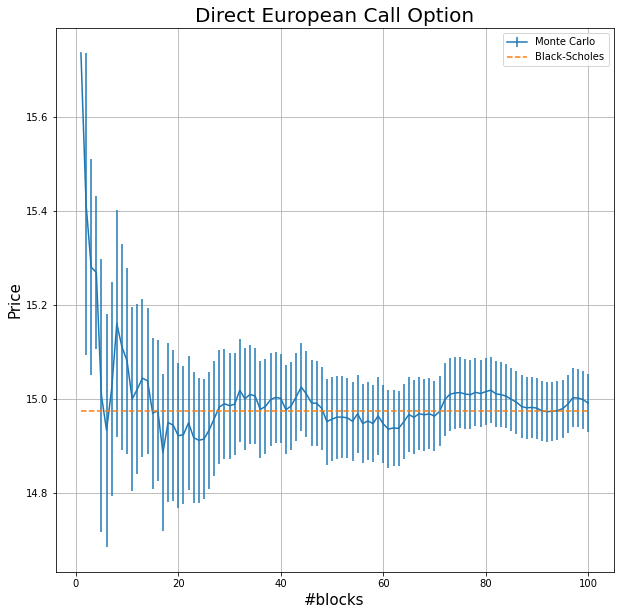

100000000 numbers generated
100 blocks
10000 paths generated per block


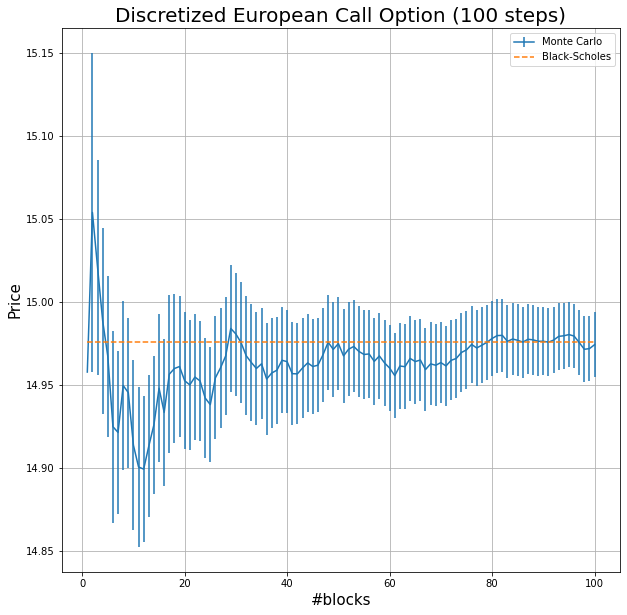

In [5]:
# (4)
# (A)

print(numbersGeneratedDirect, 'numbers generated')
numberOfBlocks = 100
pathsPerBlock = int(numbersGeneratedDirect/numberOfBlocks)
print(numberOfBlocks, 'blocks')
print(pathsPerBlock, 'paths generated per block')

if pathsPerBlock * numberOfBlocks != numbersGeneratedDirect:
    print('Warning! numbersGeneratedDirect is not a multiple of numberOfBlocks')

x = np.arange(numberOfBlocks)      # [0,1,2,...,N-1]
ave = np.zeros(numberOfBlocks)
av2 = np.zeros(numberOfBlocks)
sum_prog = np.zeros(numberOfBlocks)
su2_prog = np.zeros(numberOfBlocks)
err_prog = np.zeros(numberOfBlocks)


for i in range(numberOfBlocks):
    sum = 0
    for j in range(pathsPerBlock):
        S_T = price_evolution(S0, r, sigma, pathCallDirect[j + i * pathsPerBlock], 1)
        if S_T > K:
            sum += (S_T-K) * exp(-r*T)
    ave[i] = sum/pathsPerBlock
    av2[i] = (ave[i])**2
    
for i in range(numberOfBlocks):
    for j in range(i+1):
        sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
        su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    sum_prog[i]/=(i+1) # Cumulative average
    su2_prog[i]/=(i+1) # Cumulative square average
    err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
    
y = np.zeros(numberOfBlocks)
for i in range(numberOfBlocks):
    y[i] = call

plt.figure(figsize=(10, 10)) 
plt.title('Direct European Call Option', fontsize=titleSize)
plt.errorbar(x+1, sum_prog, yerr=err_prog, label='Monte Carlo')
plt.errorbar(x+1, y, fmt='--', label='Black-Scholes')
plt.legend(loc='upper right')
plt.xlabel('#blocks', fontsize=axesLabelSize)
plt.ylabel('Price', fontsize=axesLabelSize)
plt.grid(True)
plt.show()


print(numbersGeneratedDiscretized, 'numbers generated')
discretizedSteps = 100
numberOfBlocks = 100
pathsPerBlock = int(numbersGeneratedDiscretized/numberOfBlocks/discretizedSteps)
print(numberOfBlocks, 'blocks')
print(pathsPerBlock, 'paths generated per block')

if pathsPerBlock * numberOfBlocks * discretizedSteps != numbersGeneratedDiscretized:
    print('Warning! numbersGeneratedDiscretized is not a multiple of numberOfBlocks')

x = np.arange(numberOfBlocks)      # [0,1,2,...,N-1]
ave = np.zeros(numberOfBlocks)
av2 = np.zeros(numberOfBlocks)
sum_prog = np.zeros(numberOfBlocks)
su2_prog = np.zeros(numberOfBlocks)
err_prog = np.zeros(numberOfBlocks)


for i in range(numberOfBlocks):
    sum = 0
    for j in range(pathsPerBlock):
        
        S_T = S0
        for k in range(discretizedSteps):
            S_T = price_evolution(S_T, r, sigma, pathCallDiscretized[(discretizedSteps * (j + i * pathsPerBlock)) + k], 1/discretizedSteps)
        if S_T > K:
            sum += (S_T-K) * exp(-r*T)
    ave[i] = sum/pathsPerBlock
    av2[i] = (ave[i])**2
    
for i in range(numberOfBlocks):
    for j in range(i+1):
        sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
        su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    sum_prog[i]/=(i+1) # Cumulative average
    su2_prog[i]/=(i+1) # Cumulative square average
    err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty

plt.figure(figsize=(10, 10)) 
plt.title('Discretized European Call Option ('+str(discretizedSteps)+' steps)', fontsize=titleSize)
plt.errorbar(x+1, sum_prog, yerr=err_prog, label='Monte Carlo')
plt.errorbar(x+1, y, fmt='--', label='Black-Scholes')
plt.legend(loc='upper right')
plt.xlabel('#blocks', fontsize=axesLabelSize)
plt.ylabel('Price', fontsize=axesLabelSize)
plt.grid(True)
plt.show()

100000 numbers generated
100 blocks
1000 paths generated per block


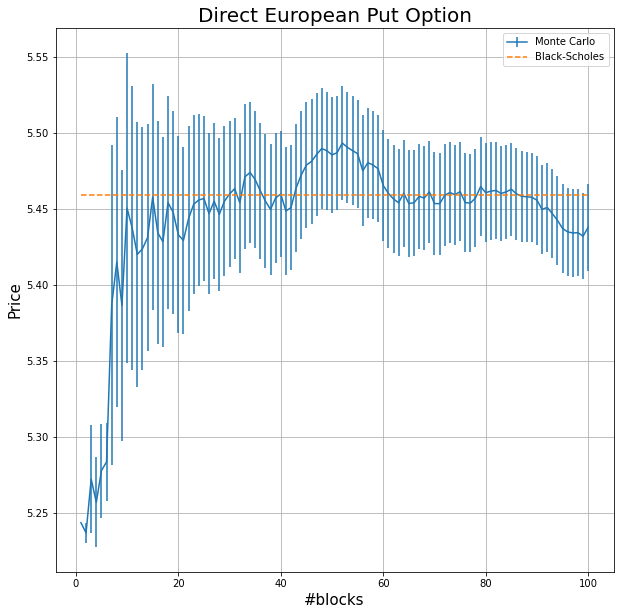

100000000 numbers generated
100 blocks
10000 paths generated per block


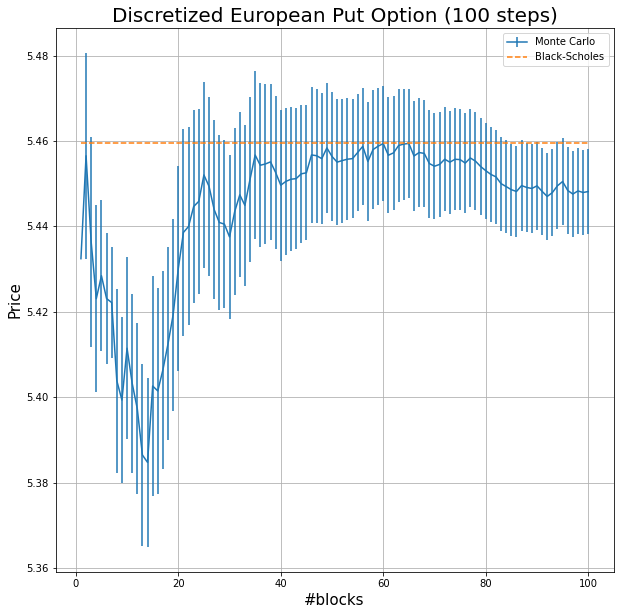

In [6]:
# (B)

print(numbersGeneratedDirect, 'numbers generated')
numberOfBlocks = 100
pathsPerBlock = int(numbersGeneratedDirect/numberOfBlocks)
print(numberOfBlocks, 'blocks')
print(pathsPerBlock, 'paths generated per block')

if pathsPerBlock * numberOfBlocks != numbersGeneratedDirect:
    print('Warning! numbersGeneratedDirect is not a multiple of numberOfBlocks')

x = np.arange(numberOfBlocks)      # [0,1,2,...,N-1]
ave = np.zeros(numberOfBlocks)
av2 = np.zeros(numberOfBlocks)
sum_prog = np.zeros(numberOfBlocks)
su2_prog = np.zeros(numberOfBlocks)
err_prog = np.zeros(numberOfBlocks)


for i in range(numberOfBlocks):
    sum = 0
    for j in range(pathsPerBlock):
        S_T = price_evolution(S0, r, sigma, pathPutDirect[j + i * pathsPerBlock], 1)
        if S_T < K:
            sum += (K-S_T) * exp(-r*T)
    ave[i] = sum/pathsPerBlock
    av2[i] = (ave[i])**2
    
for i in range(numberOfBlocks):
    for j in range(i+1):
        sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
        su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    sum_prog[i]/=(i+1) # Cumulative average
    su2_prog[i]/=(i+1) # Cumulative square average
    err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
    
y = np.zeros(numberOfBlocks)
for i in range(numberOfBlocks):
    y[i] = put

plt.figure(figsize=(10, 10)) 
plt.title('Direct European Put Option', fontsize=titleSize)
plt.errorbar(x+1, sum_prog, yerr=err_prog, label='Monte Carlo')
plt.errorbar(x+1, y, fmt='--', label='Black-Scholes')
plt.legend(loc='upper right')
plt.xlabel('#blocks', fontsize=axesLabelSize)
plt.ylabel('Price', fontsize=axesLabelSize)
plt.grid(True)
plt.show()


print(numbersGeneratedDiscretized, 'numbers generated')
discretizedSteps = 100
numberOfBlocks = 100
pathsPerBlock = int(numbersGeneratedDiscretized/numberOfBlocks/discretizedSteps)
print(numberOfBlocks, 'blocks')
print(pathsPerBlock, 'paths generated per block')

if pathsPerBlock * numberOfBlocks * discretizedSteps != numbersGeneratedDiscretized:
    print('Warning! numbersGeneratedDiscretized is not a multiple of numberOfBlocks')

x = np.arange(numberOfBlocks)      # [0,1,2,...,N-1]
ave = np.zeros(numberOfBlocks)
av2 = np.zeros(numberOfBlocks)
sum_prog = np.zeros(numberOfBlocks)
su2_prog = np.zeros(numberOfBlocks)
err_prog = np.zeros(numberOfBlocks)


for i in range(numberOfBlocks):
    sum = 0
    for j in range(pathsPerBlock):
        S_T = S0
        for k in range(discretizedSteps):
            S_T = price_evolution(S_T, r, sigma, pathPutDiscretized[(discretizedSteps * (j + i * pathsPerBlock)) + k], 1/discretizedSteps)
        if S_T < K:
            sum += (K-S_T) * exp(-r*T)
    ave[i] = sum/pathsPerBlock
    av2[i] = (ave[i])**2
    
for i in range(numberOfBlocks):
    for j in range(i+1):
        sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
        su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
    sum_prog[i]/=(i+1) # Cumulative average
    su2_prog[i]/=(i+1) # Cumulative square average
    err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty

plt.figure(figsize=(10, 10)) 
plt.title('Discretized European Put Option ('+str(discretizedSteps)+' steps)', fontsize=titleSize)
plt.errorbar(x+1, sum_prog, yerr=err_prog, label='Monte Carlo')
plt.errorbar(x+1, y, fmt='--', label='Black-Scholes')
plt.legend(loc='upper right')
plt.xlabel('#blocks', fontsize=axesLabelSize)
plt.ylabel('Price', fontsize=axesLabelSize)
plt.grid(True)
plt.show()